In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
season_code = "25_26"

current_dir = Path.cwd()  
path_folder = current_dir.parent.parent.parent / "csv" / f"csv{season_code}" / "players"
path_start  = os.path.join(path_folder, "clean/data_players.csv")
path_end    = os.path.join(path_folder, "ratings/data_players.csv")
path_end_avg    = os.path.join(path_folder, "ratings/data_players_average.csv")
path_notes = current_dir.parent.parent.parent / "csv" / f"csv24_25" / "players" / "clean" / "data_players.csv"

In [3]:
data = pd.read_csv(path_start, index_col=0)
note_max = 10

In [4]:
def rating_league(raw_note, league):
    league_weights = {
        "UEFA Champions League": 1.3,
        "French Ligue 1": 1.0,
        "German Bundesliga": 1.0,
        "Italian Serie A": 1.0,
        "Spanish La Liga": 1.1,
        "English Premier League": 1.1,
        "UEFA Europa League": 1.0,
        "UEFA Europa Conference League": 0.9
    }
    
    raw_note *= league_weights.get(league, 1.0)
    
    return round(raw_note, 2)


In [5]:
def rescale_rating(df, col="Rating", mean=5.5, std=2.5, note_max=100):
    mean = mean*note_max/10
    std = std*note_max/10
    n = len(df)
    
    ratings_gauss = np.random.normal(loc=mean, scale=std, size=n)
    
    order = df[col].rank(method="first")
    ratings_gauss_sorted = np.sort(ratings_gauss)
    df[col] = [ratings_gauss_sorted[int(r-1)] for r in order]
    
    return df

In [6]:
def get_position_indices(position):
    if position in ['AM', 'LW', 'RW']:  
        return (
            [
                "Expected Goals (xG)",
                "Shots on Target",
                "Shots Total",
                "Goal-Creating Actions (GCA)",
                "Shot-Creating Actions (SCA)",
                "Key Passes",
                "Expected Assists (xA)",
                "Passes into Penalty Area",
                "Passes into Final Third",
                "Carries into Penalty Area",
                "Carries into Final Third",
                "Progressive Passes",
                "Progressive Carries",
                "Successful Take-Ons",
                "Passes Received",
                "Touches in Attacking Third",
                "Touches in Attacking Penalty Area",
                "Offsides"
            ],
            [
                "Offsides"
            ],
            [4, 2.5, 2, 3, 3, 3, 4, 3.5, 2.5, 2.5, 2.5, 3, 3, 4, 1.5, 4, 3, 1]
        )

    elif position in ['LM', 'RM', 'CM', 'DM', 'WB']: 
        return (
            [
                "Passes Completed",
                "Progressive Passes",
                "Passes into Final Third",
                "Passes Attempted",
                "Interceptions",
                "Tackles",
                "Progressive Carries",
                "Carries into Final Third",
                "Key Passes",
                "Blocks",
                "Switches",
                "Ball Recoveries",
                "Dribblers Tackled",
                "Successful Take-Ons",
                "Passes into Penalty Area",
                "Ball Losses",
                "Errors Leading to Shot"
            ],
            [
                "Ball Losses",
                "Errors Leading to Shot"
            ],
            [2, 3, 2, 1.5, 3, 3, 2.5, 3, 3, 2, 2, 4, 3, 1.5, 2, 1, 2]
        )

    elif position in ['LB', 'RB', 'CB']:  
        return (
            [
                "Tackles",
                "Interceptions",
                "Clearances",
                "Blocks",
                "Aerials Won",
                "Ball Recoveries",
                "Dribblers Tackled",
                "Tackles in Defensive Third",
                "Passes Completed",
                "Progressive Passes",
                "Touches in Defensive Third",
                "Progressive Carries",
                "Passes Attempted",
                "Touches in Defensive Penalty Area",
                "Passes Blocked",
                "Errors Leading to Shot",
                "Own Goals",
                "Fouls Committed",
                "Ball Losses"
            ],
            [
                "Errors Leading to Shot",
                "Own Goals",
                "Fouls Committed",
                "Ball Losses"
            ],
            [3, 3, 2.5, 3, 4, 3, 2, 2, 4, 4, 4, 2, 3, 4, 3, 1, 1, 1]
        )

    else:
        raise ValueError(f"Poste inconnu ou non géré : {position}")


In [7]:
def data_by_position(data):
    positions = data['Position'].unique()
    results = {}
    
    for position in positions:
        position_data = data[data['Position'] == position]
        indices, _, _ = get_position_indices(position)
        
        results_position = position_data[indices].copy()
        results_position = results_position[indices]
        results_position.index = position_data.index
        results[position] = {stat: results_position[stat].dropna().tolist() for stat in indices}

    return results

In [8]:
def notation(data, note_max):
    results = []
    
    data_notes = pd.read_csv(path_notes)
    data_position = data_by_position(data_notes)
    #data_position = data_by_position(data)

    for idx, row in data.iterrows():
        minutes = row["Minutes"]
        if minutes < 0 :
            continue
        if minutes == 0:
            minutes = 1
            
        game_week = row['Game Week']
        position = row.get('Position')
        gen_position = row.get('General Position')
        team = row['Team']
        league = row['League']
        age = row['Age']
        nation = row['Nationality']
        
        centiles = {}
        factor = 90 / minutes
        
        indices, negative_indices, weights = get_position_indices(position)
        data_stats = data_position[position]
        
        for stat, coeff in zip(indices, weights):
            if pd.isnull(row[stat]):
                continue

            player_value = row[stat] * factor

            all_values = np.array(data_stats[stat])  

            if len(all_values) < 3:
                continue 

            if stat in negative_indices:
                centile = (all_values > player_value).sum() / len(all_values)
            else:
                centile = (all_values < player_value).sum() / len(all_values)

            centiles[stat] = centile

        if not centiles:
            continue

        raw_note = note_max * sum(centiles[stat] * coeff for stat, coeff in zip(indices, weights) if stat in centiles) / sum(weights)

        raw_note = raw_note * (1 + 0.05*row.get('Goals', 0) + 0.05*max(row.get('Assists', 0), row.get("Expected Assists (xA)", 0)))

        #rating = rating_league(raw_note, league)
        rating = raw_note
        rating = min(max(rating, 0), note_max)
        
        results.append({
            "Player": idx,
            "Game Week": game_week,
            "Position": position,
            "General Position": gen_position, 
            "Team": team,
            "League": league,
            "Minutes": minutes,
            "Rating": rating,
            "Age": age,
            "Nationality": nation
        })
        
    results = pd.DataFrame(results)
    #results = results.groupby("General Position").apply(rescale_rating).reset_index(drop=True)
    results["Rating"] = results["Rating"].round(1)
    
    return pd.DataFrame(results)

In [9]:
notes = notation(data, note_max)

In [10]:
notes.to_csv(path_end, index=False)

In [11]:
notes.head()

,Player,Game Week,Position,General Position,Team,League,Minutes,Rating,Age,Nationality
0,Andrea Pinamonti,J1,AM,Forward,Sassuolo,Italian Serie A,89.0,2.0,26,ITA
1,Luca Moro,J1,AM,Forward,Sassuolo,Italian Serie A,1.0,1.1,24,ITA
2,Armand Lauriente,J1,LW,Forward,Sassuolo,Italian Serie A,80.0,2.5,26,FRA
3,Andrea Ghion,J1,LW,Forward,Sassuolo,Italian Serie A,10.0,0.4,25,ITA
4,Domenico Berardi,J1,RW,Forward,Sassuolo,Italian Serie A,89.0,3.3,31,ITA


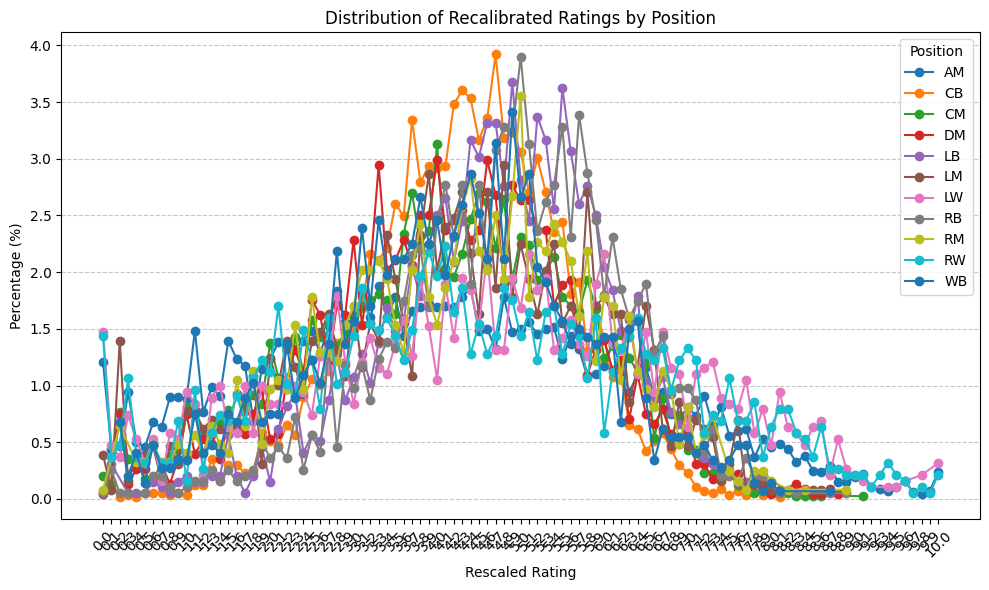

In [12]:
notes["Rating_rounded"] = notes["Rating"].round(1)

plt.figure(figsize=(10, 6))

positions = sorted(notes["Position"].dropna().unique())

for pos in positions:
    subset = notes[notes["Position"] == pos]
    dist = subset["Rating_rounded"].value_counts(normalize=True).sort_index() * 100
    plt.plot(dist.index, dist.values, marker='o', label=pos)

plt.xlabel("Rescaled Rating")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Recalibrated Ratings by Position")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(sorted(notes["Rating_rounded"].unique()), rotation=45)
plt.legend(title="Position")
plt.tight_layout()
plt.show()

In [13]:
def get_average_scores(df):
    df = df.dropna(subset=['Rating', 'Minutes'])
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Minutes'] = pd.to_numeric(df['Minutes'], errors='coerce')
    df = df[df['Minutes'] > 0]

    df["Matches"] = 1 
    
    grouped = df.groupby(["Player", "Age"]).agg({
        "Rating": 'sum',
        "Minutes": 'sum',
        "Matches": 'sum',
        "Team": lambda x: ', '.join(sorted(set(x))),
        "League": lambda x: ', '.join(sorted(set(x))),
        "Position": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        "General Position": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        "Nationality": "first"
    }).reset_index()

    return grouped

In [14]:
def merge_similar_players(df, max_age_diff=1):
    df = df.sort_values(by=["Player", "Age"]).reset_index(drop=True)
    merged_rows = []
    used_indices = set()

    for i, row_i in df.iterrows():
        if i in used_indices:
            continue
        mask = (
            (df["Player"] == row_i["Player"]) &
            (df["Nationality"] == row_i["Nationality"]) &
            (abs(df["Age"] - row_i["Age"]) <= max_age_diff)
        )
        close_rows = df[mask]
        indices = close_rows.index.tolist()
        used_indices.update(indices)
        subset = df.loc[indices]
        new_row = {}
        new_row["Player"] = row_i["Player"]
        teams = subset["Team"].dropna().apply(lambda x: [t.strip() for t in str(x).split(',')])
        flat_teams = [team for sublist in teams for team in sublist]
        new_row["Team"] = ', '.join(sorted(set(flat_teams)))
        
        leagues = set()
        for league_entry in subset["League"]:
            if isinstance(league_entry, list):
                leagues.update(league_entry)
            elif isinstance(league_entry, str) and league_entry.startswith("["): 
                try:
                    import ast
                    leagues.update(ast.literal_eval(league_entry))
                except:
                    leagues.add(league_entry)
            elif isinstance(league_entry, str):
                leagues.update([l.strip() for l in league_entry.split(",") if l.strip()])
            else:
                leagues.add(league_entry)
        new_row["League"] = ', '.join(sorted(leagues))

        for col in ["Position", "General Position", "Nationality"]:
            if col in subset.columns and not subset[col].mode().empty:
                new_row[col] = subset[col].mode().iloc[0]
            else:
                new_row[col] = None

        new_row["Age"] = int(subset["Age"].max())

        for col in ["Rating", "Minutes", "Matches"]:
            new_row[col] = subset[col].sum()

        new_row["Average Rating"] = round(new_row["Rating"] / new_row["Matches"], 2) if new_row["Matches"] > 0 else None

        merged_rows.append(pd.Series(new_row))

    df_merged = pd.DataFrame(merged_rows).round(2)

    for col in ["Minutes", "Age"]:
        if col in df_merged.columns:
            df_merged[col] = df_merged[col].astype("Int64")

    return df_merged

In [15]:
data = pd.read_csv(path_end, index_col=0)
data_bis = get_average_scores(data)
data_avg = merge_similar_players(data_bis, max_age_diff=1)
data_avg.to_csv(path_end_avg, index=False)

In [16]:
data_avg.head()

,Player,Team,League,Position,General Position,Nationality,Age,Rating,Minutes,Matches,Average Rating
0,Aaron Anselmino,Dortmund,"German Bundesliga, UEFA Champions League",CB,Defender,ARG,20,33.9,518,8,4.24
1,Aaron Bouwman,Ajax,UEFA Champions League,CB,Defender,NED,18,4.7,90,1,4.70
2,Aaron Greene,Shamrock Rovers,UEFA Europa Conference League,CM,Midfielder,IRL,35,2.4,4,1,2.40
3,Aaron Hickey,Brentford,English Premier League,LB,Defender,SCO,23,38.0,416,10,3.80
4,Aaron McEneff,"Shamrock Rov, Shamrock Rovers",UEFA Europa Conference League,CM,Midfielder,IRL,30,5.9,134,3,1.97
